# Random walks $R_t$ factor with Gamma-Poisson likelihood

In [1]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import pymc3 as pm
from matplotlib import pyplot as plt
import theano.tensor as tt

In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.figsize': [10, 5]})

Download the data - if you re-run the notebook in the same data, keep this cell commented-out so it does not re-download the data each time.

In [3]:
import requests as rq
q = rq.get('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')
with open('RKI_COVID19.csv', 'wb') as f:
    f.write(q.content)

Specify your filters. You can use Landkreis or Bundesland.

In [5]:
filters = {'Landkreis': 'SK Düsseldorf'}

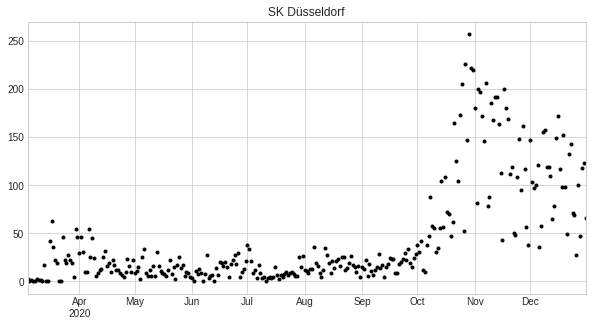

In [6]:
data = pd.read_csv('RKI_COVID19.csv')
data = data.assign(date = pd.to_datetime(data.Meldedatum))

for k, v in filters.items():
    data = data[data[k] == v]

data = data.groupby(['date']).AnzahlFall.sum().rename('cases').sort_index()

# fill missing dates with zeros
data = (pd.date_range(data.index.min(), data.index.max(), name='date').to_frame()
        .join(data, how='left').fillna(0).astype('int').cases)

data.plot(marker='.', linewidth=0, color='k')
plt.gca().set(title=tuple(filters.items())[0][1], xlabel='')
None


## Model

We model the new daily cases as simple reproduction with a Gamma-Poisson likelihood (aka. Negative Binomial):

$$ \text{cases}_t \sim \text{NB}(\mu_t, \alpha) $$

where the daily $\mu_t$ is corrected with a multiplicative factor depending of the weekday:

$$ \mu_t = \overline{\mu}_t \exp{w_{d_t}}  $$

The latent daily parameter $\overline{\mu}_t$ is simply a multiple of the day before:

$$ \overline{\mu}_{t+1} = R_t  \overline{\mu}_t $$

which can be rewriten as (note: $\overline{\mu}_0 = 1$):

$$ \log \overline{\mu}_{t+1} = \log \overline{\mu}_{t} + \log R_t $$

$$ \log \overline{\mu}_t = \sum_{\tau=1}^t \log R_{\tau} $$

We will model the $R_t$ as Gaussian random walk prior in the log scale (the factor is always positive):

$$ \log R_{t+1} \sim \mathcal{N}(\log R_t, \sigma^2) $$

and a regularizing hyperprior for $\sigma$:

$$ \sigma \sim \text{Exponential}\big(\frac{1}{0.05}\big) $$

We model the weekday correction $w$ using partial pooling:

$$ w_d \sim \mathcal{N}(0, \theta^2), d = (0, \ldots , 6) $$

$$ \theta \sim \text{Exponential}(1) $$

Finally, for the dispersion parameter we will use Cauchy prior:

$$ \alpha \sim \text{Half-Cauchy}(5) $$

In [7]:
N = data.shape[0]
weekday = data.index.to_series().dt.weekday.values
scale = 5

with pm.Model() as model5:

    sigma = pm.Exponential('sigma', 1/0.05)
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 1),
        sigma=sigma,
        shape=N
    )

    R = pm.Deterministic('R', tt.exp(logR))
    mu_bar = pm.Deterministic('mu_bar', tt.exp(tt.cumsum(logR)))

    theta = pm.Exponential('theta', 1)
    w = pm.Normal('w', 0, theta, shape=7)
    exp_w = tt.exp(w)

    mu = pm.Deterministic('mu', mu_bar * exp_w[weekday])

    _alpha = pm.HalfCauchy('_alpha', 1)
    alpha = _alpha * scale
    pm.NegativeBinomial('obs', mu=mu, alpha=alpha,
                        observed=data.values)

    trace5 = pm.sample(10000, tune=3000, chains=2, cores=2)

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [_alpha, w, theta, logR, sigma]


Sampling 2 chains for 3_000 tune and 10_000 draw iterations (6_000 + 20_000 draws total) took 190 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


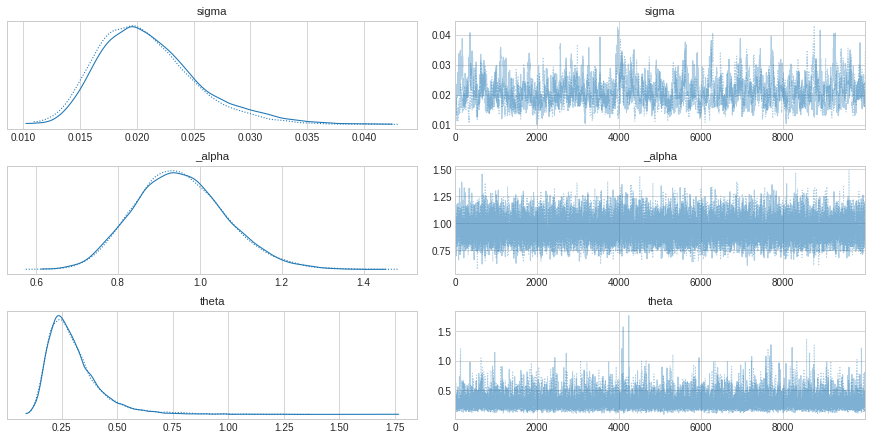

In [8]:
pm.traceplot(trace5, var_names=['sigma', '_alpha', 'theta'])
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


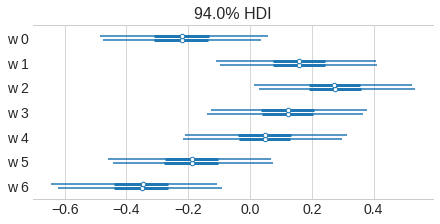

In [9]:
pm.plot_forest(trace5, var_names=['w'], figsize=(6, 3))
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/li

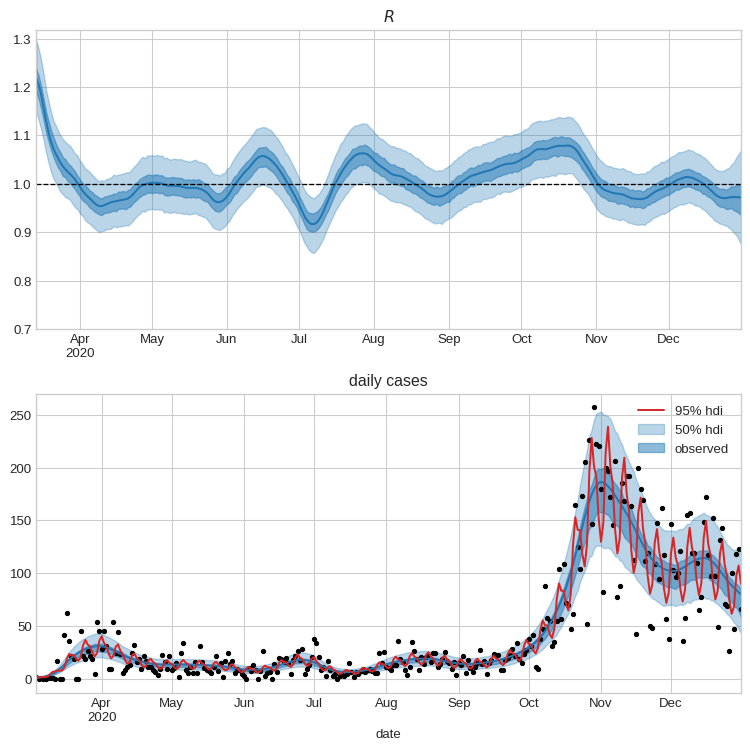

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=95)

tmp = pm.hpd(trace5['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.index)
tmp = tmp.assign(mean_ = trace5['R'].mean(axis=0))
tmp = tmp.iloc[10:]
tmp.mean_.plot(ax=ax1)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.3, color='C0')

tmp = pm.hpd(trace5['R'] , hdi_prob=0.50)
tmp = pd.DataFrame(tmp, index=data.index)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.5, color='C0')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R$', xlabel='', ylim=(0.7, None))

tmp = pm.hpd(trace5['mu_bar'], hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.index)
tmp = tmp.assign(mean_ = trace5['mu_bar'].mean(axis=0))
tmp.mean_.plot(label='')
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.3, color='C0', label='95% hdi')

tmp = pm.hpd(trace5['mu_bar'], hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data.index)
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.5, color='C0', label='50% hdi')

ax2.scatter(data.index, data, color='k', label='observed', marker='.')
ax2.set(title='daily cases', xlabel='')
ax2.legend(loc='upper left')

# this will plot the daily correction as well
tmp = pd.Series(trace5['mu'].mean(axis=0), index=data.index)
# ax2.(tmp.index, tmp[0].values, tmp[1].values, alpha=.1, color='C2')
tmp.plot(ax=ax2, color='C3')

fig.tight_layout()
None

### Model without daily measurent correction

In [18]:
N = data.shape[0]
weekday = data.index.to_series().dt.weekday.values
scale = 5

with pm.Model() as model6:

    sigma = pm.Exponential('sigma', 1/0.05)
    logR = pm.GaussianRandomWalk(
        'logR',
        init=pm.Normal.dist(0, 1),
        sigma=sigma,
        shape=N
    )

    R = pm.Deterministic('R', tt.exp(logR))
    mu = pm.Deterministic('mu', tt.exp(tt.cumsum(logR)))

    _alpha = pm.HalfCauchy('_alpha', 1)
    alpha = _alpha * scale
    pm.NegativeBinomial('obs', mu=mu, alpha=alpha,
                        observed=data.values)

    trace6 = pm.sample(5000, tune=3000, chains=2, cores=2)

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [_alpha, logR, sigma]


Sampling 2 chains for 3_000 tune and 5_000 draw iterations (6_000 + 10_000 draws total) took 93 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


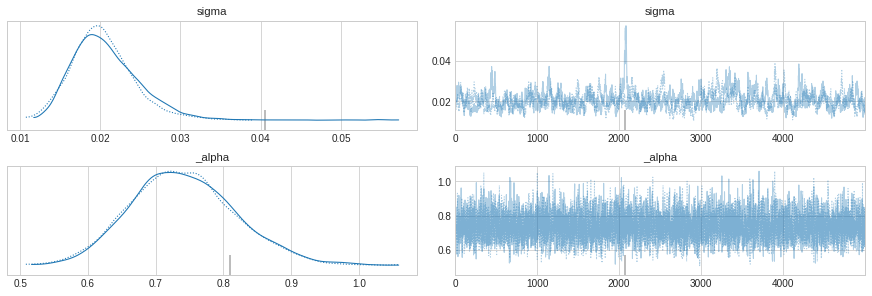

In [20]:
pm.traceplot(trace6, var_names=['sigma', '_alpha'])
None

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(
/home/petrushev/etc/jupenv/li

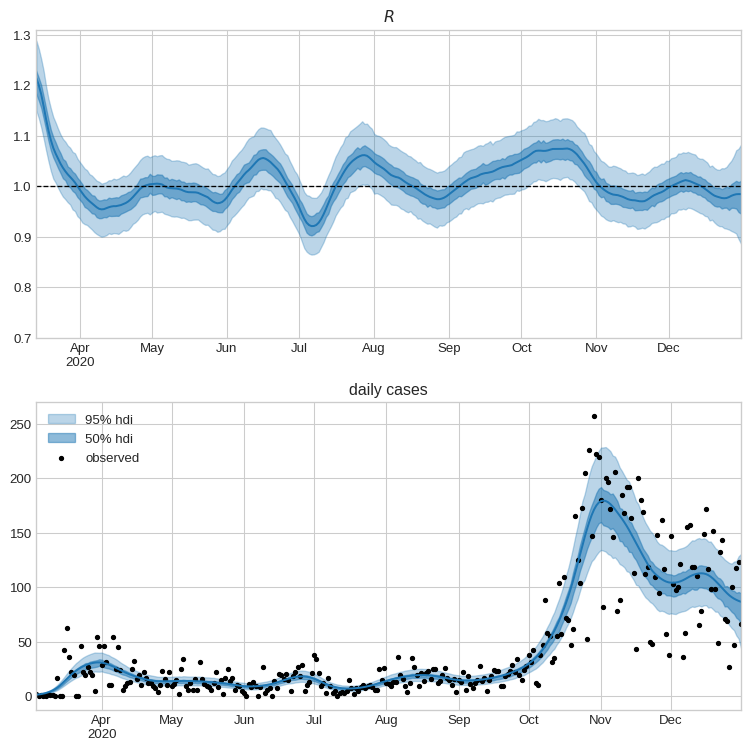

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), dpi=95)

tmp = pm.hpd(trace6['R'] , hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.index)
tmp = tmp.assign(mean_ = trace6['R'].mean(axis=0))
tmp = tmp.iloc[10:]
tmp.mean_.plot(ax=ax1)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.3, color='C0')

tmp = pm.hpd(trace6['R'] , hdi_prob=0.50)
tmp = pd.DataFrame(tmp, index=data.index)
ax1.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.5, color='C0')

ax1.axhline(1, linestyle='--', linewidth=1, color='k')
ax1.set(title='$R$', xlabel='', ylim=(0.7, None))

tmp = pm.hpd(trace6['mu'], hdi_prob=0.95)
tmp = pd.DataFrame(tmp, index=data.index)
tmp = tmp.assign(mean_ = trace6['mu'].mean(axis=0))
tmp.mean_.plot(label='')
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.3, color='C0', label='95% hdi')

tmp = pm.hpd(trace6['mu'], hdi_prob=0.5)
tmp = pd.DataFrame(tmp, index=data.index)
ax2.fill_between(tmp.index, tmp[0].values, tmp[1].values, alpha=.5, color='C0', label='50% hdi')

ax2.scatter(data.index, data, color='k', label='observed', marker='.')
ax2.set(title='daily cases', xlabel='')
ax2.legend(loc='upper left')

fig.tight_layout()
None

In [23]:
pm.compare({
    '5': trace5,
    '6': trace6
}, ic='waic')

/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:149: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/petrushev/etc/jupenv/lib/python3.9/site-packages/arviz/stats/stats.py:1425: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/petrushev/etc/jupenv/lib/pyth

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
5,0,-1204.7,28.5907,0,0.999725,21.5723,0,True,log
6,1,-1227.39,20.3609,22.6918,0.000274504,20.899,6.90441,True,log
